In [1]:
import os
from pathlib import Path

from itertools import chain, product

import datetime

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import time
import datetime
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
os.getcwd()

'/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/code/gbq_city'

In [3]:

os.chdir('/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/')

In [18]:
# config settings

# date of forecast generation
# pick 5 days
# c("2023-10-01", "2023-11-19", "2024-01-07", "2024-02-18", "2024-03-24")
forecast_date = datetime.date(2024, 3, 23) #datetime.date.today()
print(f'forecast date = {forecast_date}')

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - datetime.timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# include measures of level among features?
incl_level_feats = False

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 10
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.01', '0.025', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35',
            '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8',
            '0.85', '0.9', '0.95', '0.975', '0.99']

# seed for random number generation, based on reference date
rng_seed = int(time.mktime(ref_date.timetuple()))
rng = np.random.default_rng(seed=rng_seed)
# seeds for lgb model fits, one per combination of bag and quantile level
lgb_seeds = rng.integers(1e8, size=(num_bags, len(q_levels)))

forecast date = 2024-03-23
reference date = 2024-03-30


In [19]:
city_mapping = {
    'New York - Albany': 'Albany',
    'New York - Rochester': 'Rochester'
}

state_mapping = {
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Georgia': 'GA',
    'Maryland': 'MD',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'New Mexico': 'NM',
    'New York - Albany': 'NY',
    'New York - Rochester': 'NY',
    'Ohio': 'OH',
    'Oregon': 'OR',
    'Tennessee': 'TN',
    'Utah': 'UT'
}

def date_to_ew_str(row, date_col_name='wk_end_date'):
    ew = pymmwr.date_to_epiweek(datetime.date.fromisoformat(row[date_col_name]))
    # ew_str = pd.Series(str(ew.year) + str(ew.week))
    ew_str = str(ew.year) + str(ew.week)
    return ew_str



# convert epi week to season week
def convert_epiweek_to_season_week(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season_week: integer between 1 and 52
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  season_week = epiweek_week - 30

  update_inds = (season_week <= 0)
  season_week[update_inds] = season_week[update_inds] + \
    [pymmwr.epiweeks_in_year(int(epiweek_year[update_inds].values[i]) - 1) for i in range(np.sum(update_inds))]
  
  return season_week



def convert_epiweek_to_season(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season: string in format '2018/19'
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  update_inds = (epiweek_week <= 30)
  epiweek_year = epiweek_year - update_inds
  season = epiweek_year.astype(str)
  season = season + '/' + (season.str[-2:].astype(int) + 1).astype(str)
  
  return season



def load_fips_mappings():
  return pd.read_csv('data-raw/fips-mappings/fips_mappings.csv')



def load_flusurv_rates_2022_23():
  dat = pd.read_csv('data-raw/influenza-flusurv/flusurv-rates/flusurv-rates-2022-23.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  
  dat = dat.loc[(dat['age category'] == 'Overall') &
                (dat['sex category'] == 'Overall') &
                (dat['race category'] == 'Overall')]
  
  dat = dat.loc[~((dat.catchment == 'Entire Network') &
                  (dat.network != "FluSurv-NET"))]

  dat['location'] = dat['catchment']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat['season'] = dat['year'].str.replace('-', '/')
  epiweek = dat['mmwr-year'].astype(str) + dat['mmwr-week'].astype(str)
  dat['season_week'] = convert_epiweek_to_season_week(epiweek)
  dat['wk_end_date'] = dat.apply(
    lambda x: pymmwr.epiweek_to_date(pymmwr.Epiweek(year=x['mmwr-year'],
                                                    week=x['mmwr-week'],
                                                    day=7))
                                    .strftime("%Y-%m-%d"),
      axis=1)
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  dat['inc'] = dat['weekly rate ']
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  return dat



def load_flusurv_rates_base(seasons=None,
                            locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                      'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                      'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                      'Tennessee', 'Utah'],
                            age_labels=['0-4 yr', '5-17 yr', '18-49 yr', '50-64 yr', '65+ yr', 'Overall']
                            ):
  # read flusurv data and do some minimal preprocessing
  dat = pd.read_csv('data-raw/influenza-flusurv/flusurv-rates/old-flusurv-rates.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  dat['season'] = dat.sea_label.str.replace('-', '/')
  dat['inc'] = dat.weeklyrate
  dat['location'] = dat['region']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat = dat[(dat.age_label.isin(age_labels)) & (dat.location.isin(locations))]
  if seasons is not None:
    dat = dat[dat.season.isin(seasons)]
  
  dat = dat.sort_values(by=['wk_end'])
  
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end'])
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat = pd.concat(
    [dat, load_flusurv_rates_2022_23()],
    axis = 0
  )

  dat['source'] = 'flusurvnet'
  
  return dat


def load_one_us_census_file(f):
  dat = pd.read_csv(f, engine='python', dtype={'STATE': str})
  dat = dat.loc[(dat['NAME'] == 'United States') | (dat['STATE'] != '00'),
                (dat.columns == 'STATE') | (dat.columns.str.startswith('POPESTIMATE'))]
  dat = dat.melt(id_vars = 'STATE', var_name='season', value_name='pop')
  dat.rename(columns={'STATE': 'location'}, inplace=True)
  dat.loc[dat['location'] == '00', 'location'] = 'US'
  dat['season'] = dat['season'].str[-4:]
  dat['season'] = dat['season'] + '/' + (dat['season'].str[-2:].astype(int) + 1).astype(str)
  
  return dat


def load_us_census(fillna = True):
  files = [
    'data-raw/us-census/nst-est2019-alldata.csv',
    'data-raw/us-census/NST-EST2022-ALLDATA.csv']
  us_pops = pd.concat([load_one_us_census_file(f) for f in files], axis=0)
  
  fips_mappings = pd.read_csv('data-raw/fips-mappings/fips_mappings.csv')
  
  hhs_pops = us_pops.query("location != 'US'") \
    .merge(
        fips_mappings.query("location != 'US'") \
            .assign(hhs_region=lambda x: 'Region ' + x['hhs_region'].astype(int).astype(str)),
        on='location',
        how = 'left'
    ) \
    .groupby(['hhs_region', 'season']) \
    ['pop'] \
    .sum() \
    .reset_index() \
    .rename(columns={'hhs_region': 'location'})
  
  dat = pd.concat([us_pops, hhs_pops], axis=0)
  
  if fillna:
    all_locations = dat['location'].unique()
    all_seasons = [str(y) + '/' + str(y+1)[-2:] for y in range(1997, 2024)]
    full_result = pd.DataFrame.from_records(product(all_locations, all_seasons))
    full_result.columns = ['location', 'season']
    dat = full_result.merge(dat, how='left', on=['location', 'season']) \
      .set_index('location') \
      .groupby(['location']) \
      .bfill() \
      .groupby(['location']) \
      .ffill() \
      .reset_index()
  
  return dat


def load_hosp_burden():
  burden_estimates = pd.read_csv(
    'data-raw/burden-estimates/burden-estimates.csv',
    engine='python')

  burden_estimates.columns = ['season', 'hosp_burden']

  #burden_estimates['hosp_burden'] = burden_estimates['hosp_burden'].astype(int)

  burden_estimates['season'] = burden_estimates['season'].str[:4] + '/' + burden_estimates['season'].str[7:9]

  return burden_estimates


def calc_hosp_burden_adj():
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations= ['Entire Network'],
    age_labels = ['Overall']
  )

  burden_adj = dat[dat.location == 'Entire Network'] \
    .groupby('season')['inc'] \
    .sum()
  burden_adj = burden_adj.reset_index()
  burden_adj.columns = ['season', 'cum_rate']

  us_census = load_us_census().query("location == 'US'").drop('location', axis=1)
  burden_adj = pd.merge(burden_adj, us_census, on='season')

  burden_estimates = load_hosp_burden()
  burden_adj = pd.merge(burden_adj, burden_estimates, on='season')

  burden_adj['reported_burden_est'] = burden_adj['cum_rate'] * burden_adj['pop'] / 100000
  burden_adj['adj_factor'] = burden_adj['hosp_burden'] / burden_adj['reported_burden_est']

  return burden_adj


def fill_missing_flusurv_dates_one_location(location_df):
  df = location_df.set_index('wk_end_date') \
    .asfreq('W-sat') \
    .reset_index()
  fill_cols = ['agg_level', 'location', 'season', 'pop', 'source']
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
  return df


def load_flusurv_rates(burden_adj=True,
                       locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                'Tennessee', 'Utah']
                       ):
  # read flusurv data and do some minimal preprocessing
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations = locations,
    age_labels = ['Overall']
  )
  
  # if requested, make adjustments for overall season burden
  if burden_adj:
    hosp_burden_adj = calc_hosp_burden_adj()
    dat = pd.merge(dat, hosp_burden_adj, on='season')
    dat['inc'] = dat['inc'] * dat['adj_factor']
  
  # fill in missing dates
  gd = dat.groupby('location')
  
  dat = pd.concat(
    [fill_missing_flusurv_dates_one_location(df) for _, df in gd],
    axis = 0)
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc', 'source']]
  
  return dat


def load_who_nrevss_positive():
  dat = pd.read_csv('data-raw/influenza-who-nrevss/who-nrevss.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'percent_positive']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  return dat


def load_ilinet(response_type='rate',
                scale_to_positive=True,
                drop_pandemic_seasons=True,
                burden_adj=False):
  # read ilinet data and do some minimal preprocessing
  files = ['data-raw/influenza-ilinet/ilinet.csv',
           'data-raw/influenza-ilinet/ilinet_hhs.csv',
           'data-raw/influenza-ilinet/ilinet_state.csv']
  dat = pd.concat(
    [ pd.read_csv(f, encoding='ISO-8859-1', engine='python') for f in files ],
    axis = 0)
  
  if response_type == 'rate':
    dat['inc'] = np.where(dat['region_type'] == 'States',
                          dat['unweighted_ili'],
                          dat['weighted_ili'])
  else:
    dat['inc'] = dat.ilitotal

  dat['wk_end_date'] = pd.to_datetime(dat['week_start']) + pd.Timedelta(6, 'days')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  dat = dat.sort_values(by=['season', 'season_week'])
  
  # for early seasons, drop out-of-season weeks with no reporting
  early_seasons = [str(yyyy) + '/' + str(yyyy + 1)[2:] for yyyy in range(1997, 2002)]
  early_in_season_weeks = [w for w in range(10, 43)]
  first_report_season = ['2002/03']
  first_report_in_season_weeks = [w for w in range(10, 53)]
  dat = dat[
    (dat.season.isin(early_seasons) & dat.season_week.isin(early_in_season_weeks)) |
    (dat.season.isin(first_report_season) & dat.season_week.isin(first_report_in_season_weeks)) |
    (~dat.season.isin(early_seasons + first_report_season))]
  
  # region 10 data prior to 2010/11 is bad, drop it
  dat = dat[
    ~((dat['location'] == 'Region 10') & (dat['season'] < '2010/11'))
  ]
  
  if scale_to_positive:
    dat = pd.merge(
      left=dat,
      right=load_who_nrevss_positive(),
      how='left',
      on=['agg_level', 'location', 'season', 'season_week'])
    dat['inc'] = dat['inc'] * dat['percent_positive'] / 100.0
    dat.drop('percent_positive', axis=1)

  if drop_pandemic_seasons:
    dat.loc[dat['season'].isin(['2008/09', '2009/10', '2020/21', '2021/22']), 'inc'] = np.nan

  # if requested, make adjustments for overall season burden
  # if burden_adj:
  #   hosp_burden_adj = calc_hosp_burden_adj()
  #   dat = pd.merge(dat, hosp_burden_adj, on='season')
  #   dat['inc'] = dat['inc'] * dat['adj_factor']

  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'ilinet'
  return dat



def load_hhs(rates=True):
  dat = pd.read_csv("data-raw/influenza-hhs/hhs.csv")
  dat.rename(columns={'date': 'wk_end_date'}, inplace=True)

  ew_str = dat.apply(date_to_ew_str, axis=1)
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  
  if rates:
    pops = load_us_census()
    dat = dat.merge(pops, on = ['location', 'season'], how='left') \
      .assign(inc=lambda x: x['inc'] / x['pop'] * 100000)

  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  
  dat['agg_level'] = np.where(dat['location'] == 'US', 'national', 'state')
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'hhs'
  return dat


def load_nhsn_state():
  dat = pd.read_csv("data-raw/influenza-nhsn/state_level_data.csv")
  dat.rename(columns={'week_date': 'wk_end_date'}, inplace=True)

  ew_str = dat.apply(date_to_ew_str, axis=1)
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  dat['inc'] = dat['confirmed_influenza']/(dat['state_2023']/ 100000)
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])-pd.Timedelta(days=1)
  dat['city'] = ''
  dat = dat[['state', 'city', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'nhsn_state'
  return dat

def load_nhsn_city():
  dat = pd.read_csv("data-raw/influenza-nhsn/city_level_hhs.csv")
  dat.rename(columns={'collection_week': 'wk_end_date'}, inplace=True)
  dat = dat[dat['city_2023'].notna()]
  ew_str = dat.apply(date_to_ew_str, axis=1)
  ew_str
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  dat['inc'] = dat['influenza_7_day_sum']/(dat['city_2023']/ 100000)
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])-pd.Timedelta(days=1)
  dat = dat[['state', 'city', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'nhsn_city'
  return dat


def load_flusurv_rates_city(burden_adj=True,
                       locations=['California', 'Colorado', 'Connecticut',
                                'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                'Tennessee', 'Utah'],
                        ):
  fips_mappings = pd.read_csv('data-raw/fips-mappings/fips_mappings.csv')
  # read flusurv data and do some minimal preprocessing
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations = locations,
    age_labels = ['Overall']
  )
  
  # if requested, make adjustments for overall season burden
  if burden_adj:
    hosp_burden_adj = calc_hosp_burden_adj()
    dat = pd.merge(dat, hosp_burden_adj, on='season')
    dat['inc'] = dat['inc'] * dat['adj_factor']
  
  # fill in missing dates
  gd = dat.groupby('location')
  
  dat = pd.concat(
    [fill_missing_flusurv_dates_one_location(df) for _, df in gd],
    axis = 0)
  dat['state'] = dat['location'].map(state_mapping)
  dat['city'] = dat['location'].map(city_mapping).fillna('')

  dat = dat[['agg_level', 'state', 'city', 'season', 'season_week', 'wk_end_date', 'inc', 'source']]
  
  return dat


def state_city_population():
  dat = pd.read_csv("data-raw/influenza-nhsn/city_level_hhs.csv")
  dat = dat[dat['city_2023'].notna()]
  dat = dat[['state', 'city', 'state_2023', 'city_2023']]
  unique_dat = dat.drop_duplicates()
  return(unique_dat)


def get_season_hol(start_year):
  holiday_cal = USFederalHolidayCalendar()
  hol = holiday_cal.holidays(
    start=datetime.datetime(year=start_year, month=7, day=1),
    end=datetime.datetime(year=start_year+1, month=6, day=1),
    return_name=True)
    
  hol = hol.reset_index()
  hol.columns = ['date', 'holiday']
  hol = hol.loc[hol['holiday'].isin(['Thanksgiving Day', 'Christmas Day'])]
  
  hol['season'] = str(start_year) + '/' + str(start_year + 1)[-2:]
  
  return hol



def convert_datetime_to_season_week(row, date_col_name):
  ew = pymmwr.date_to_epiweek(row[date_col_name].date())
  ew_str = pd.Series(str(ew.year) + str(ew.week))
  return convert_epiweek_to_season_week(ew_str)



def get_holidays():
  hol = pd.concat([get_season_hol(sy) for sy in range(1997, 2024)],
                  ignore_index=True)
  hol['season_week'] = hol.apply(convert_datetime_to_season_week, axis=1, date_col_name='date')
  
  return hol[['season', 'holiday', 'date', 'season_week']]


In [20]:
def load_data():
    df_nhsn_state = load_nhsn_state()
    df_nhsn_state = df_nhsn_state[df_nhsn_state['season'].isin(['2022/23', '2023/24'])] 
    df_nhsn_state['state_city'] = df_nhsn_state['state']

    df_nhsn_city = load_nhsn_city()
    df_nhsn_city = df_nhsn_city[df_nhsn_city['season'].isin(['2022/23', '2023/24'])]
    #df_nhsn_city = df_nhsn_city[df_nhsn_city['state'].isin(['NY', 'CA', 'IL', 'TX', 'AZ', 'PA'])]
    #df_nhsn_city = df_nhsn_city[df_nhsn_city['city'].isin(['NEW YORK', 'ALBANY', 'ROCHESTER', 'LOS ANGELES', 
    #                                                        'CHICAGO', 'HOUSTON', 'PHOENIX', 'PHILADELPHIA',
    #                                                        'AUSTIN', 'DALLAS', 'SAN ANTONIO', 'EL PASO'])]
    df_nhsn_city['city'] = df_nhsn_city['city'].str.replace(' ', '_')
    df_nhsn_city['state_city'] = df_nhsn_city['state'] + '_' + df_nhsn_city['city']


    df_flusurv_by_site_city = load_flusurv_rates_city()
    df_flusurv_by_site_city = df_flusurv_by_site_city[df_flusurv_by_site_city['agg_level'].isin(['site'])]
    df_flusurv_by_site_city['city'] = df_flusurv_by_site_city['city'].str.upper()
    df_flusurv_by_site_city['state_city'] = df_flusurv_by_site_city.apply(
        lambda row: f"{row['state']}_{row['city'].replace(' ', '_')}" if row['city'] != '' else row['state'],
        axis=1) 
    df_original_columns = df_flusurv_by_site_city[['state', 'city', 'state_city']].drop_duplicates()


    df_flusurv_by_site_city = df_flusurv_by_site_city.groupby(['state_city', 'season', 'season_week', 'wk_end_date', 'source']) \
        .apply(lambda x: pd.DataFrame({'inc': [np.mean(x['inc'])]})) \
        .reset_index() \
        .drop(columns = ['level_5'])

    df_flusurv_by_site_city = df_flusurv_by_site_city.merge(df_original_columns, on='state_city', how='left')

    us_census = load_us_census()
    aa = pd.read_csv('data-raw/fips-mappings/fips_mappings.csv',
                        encoding='ISO-8859-1',
                        engine='python')
    us_census = us_census.merge(aa, how = 'left', on = 'location')\
        .rename(columns={'abbreviation': 'state'})\
        .drop(columns=['location_name', 'hhs_region'])
    city_census = pd.read_csv("data-raw/influenza-nhsn/city_level_hhs.csv")
    city_census = city_census[city_census['city_2023'].notna()]
    city_census = city_census[['state', 'city', 'city_2023']].drop_duplicates()
    city_census.rename(columns={'city_2023': 'pop'}, inplace=True)
    city_census['city'] = city_census['city'].str.replace(' ', '_')


    df_nhsn_state = df_nhsn_state.merge(us_census, how='left', on=['state', 'season'])
    df_flusurv_state = df_flusurv_by_site_city[df_flusurv_by_site_city['city'] == '']
    df_flusurv_city = df_flusurv_by_site_city[df_flusurv_by_site_city['city'] != '']

    df_flusurv_state = df_flusurv_state.merge(us_census, how='left', on=['state', 'season'])
    df_flusurv_city = df_flusurv_city.merge(city_census, how='left', on=['state', 'city'])

    df_nhsn_city = df_nhsn_city.merge(city_census, how='left', on=['state', 'city'])

    group_counts = df_nhsn_city.groupby('state_city').size()
    filtered_counts = group_counts[group_counts < 91]
    unique_states = filtered_counts.index
    df_nhsn_city = df_nhsn_city[~df_nhsn_city['state_city'].isin(unique_states)]

    df = pd.concat(
        [df_nhsn_state, df_nhsn_city, df_flusurv_state, df_flusurv_city],
        axis=0).sort_values(['source', 'state_city', 'wk_end_date'])
    df = df[df['pop']>=100000]
    # log population
    df['log_pop'] = np.log(df['pop'])
    #df = df[df['wk_end_date'] <= forecast_date]
        

    # process response variable:
    # - fourth root transform to stabilize variability
    # - divide by location- and source- specific 95th percentile
    # - center relative to location- and source- specific mean
    #   (note non-standard order of center/scale)
    df['inc_4rt'] = (df['inc'] + 0.01)**0.25
    df['inc_4rt_scale_factor'] = df \
        .assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                    np.nan,
                                                    x['inc_4rt'])) \
        .groupby(['source', 'state_city'])['inc_4rt_in_season'] \
        .transform(lambda x: x.quantile(0.95))

    df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
    df['inc_4rt_center_factor'] = df \
        .assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                    np.nan,
                                                    x['inc_4rt_cs'])) \
        .groupby(['source', 'state_city'])['inc_4rt_cs_in_season'] \
        .transform(lambda x: x.mean())
    df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
    df.drop(columns=['state', 'city'])
    return(df)


In [21]:
df = load_data()
df

,state,city,season,season_week,wk_end_date,inc,source,state_city,location,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,CA,,2010/11,10.0,2010-10-09,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
1,CA,,2010/11,11.0,2010-10-16,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
2,CA,,2010/11,12.0,2010-10-23,0.000000,flusurvnet,CA,06,37319502.0,17.435027,0.316228,1.943371,-0.432545,0.594433
3,CA,,2010/11,13.0,2010-10-30,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
4,CA,,2010/11,14.0,2010-11-06,0.000000,flusurvnet,CA,06,37319502.0,17.435027,0.316228,1.943371,-0.432545,0.594433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,WY,,2023/24,36.0,2024-03-30,5.992566,nhsn_state,WY,56,581381.0,13.273162,1.565252,2.349376,0.060048,0.603370
4805,WY,,2023/24,37.0,2024-04-06,2.739459,nhsn_state,WY,56,581381.0,13.273162,1.287691,2.349376,-0.057593,0.603370
4859,WY,,2023/24,38.0,2024-04-13,1.883378,nhsn_state,WY,56,581381.0,13.273162,1.173031,2.349376,-0.106191,0.603370
4966,WY,,2023/24,39.0,2024-04-20,1.369729,nhsn_state,WY,56,581381.0,13.273162,1.083798,2.349376,-0.144012,0.603370


In [22]:
df['wk_end_date'] = pd.to_datetime(df['wk_end_date'])
#forecast_date = datetime.date(2023, 9, 30)
forecast_date = pd.to_datetime(forecast_date)

# Filter the DataFrame based on the comparison
df = df[df['wk_end_date'] <= forecast_date]
df

,state,city,season,season_week,wk_end_date,inc,source,state_city,location,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,CA,,2010/11,10.0,2010-10-09,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
1,CA,,2010/11,11.0,2010-10-16,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
2,CA,,2010/11,12.0,2010-10-23,0.000000,flusurvnet,CA,06,37319502.0,17.435027,0.316228,1.943371,-0.432545,0.594433
3,CA,,2010/11,13.0,2010-10-30,0.432044,flusurvnet,CA,06,37319502.0,17.435027,0.815392,1.943371,-0.177005,0.594433
4,CA,,2010/11,14.0,2010-11-06,0.000000,flusurvnet,CA,06,37319502.0,17.435027,0.316228,1.943371,-0.432545,0.594433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4481,WY,,2023/24,31.0,2024-02-24,12.841212,nhsn_state,WY,56,581381.0,13.273162,1.893372,2.349376,0.199119,0.603370
4535,WY,,2023/24,32.0,2024-03-02,10.101754,nhsn_state,WY,56,581381.0,13.273162,1.783227,2.349376,0.152435,0.603370
4589,WY,,2023/24,33.0,2024-03-09,5.650133,nhsn_state,WY,56,581381.0,13.273162,1.542434,2.349376,0.050377,0.603370
4643,WY,,2023/24,34.0,2024-03-16,5.136485,nhsn_state,WY,56,581381.0,13.273162,1.506183,2.349376,0.035012,0.603370


/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_74256/831588450.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=nhsn_state_to_plot,
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_74256/831588450.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=nhsn_city_to_plot,
/var/folders/57/pf1ss2_n1sn5cdzq_nk8v7sm0000gr/T/ipykernel_74256/831588450.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=flusurv_to_plot,


<Axes: xlabel='season_week', ylabel='inc_4rt_cs'>

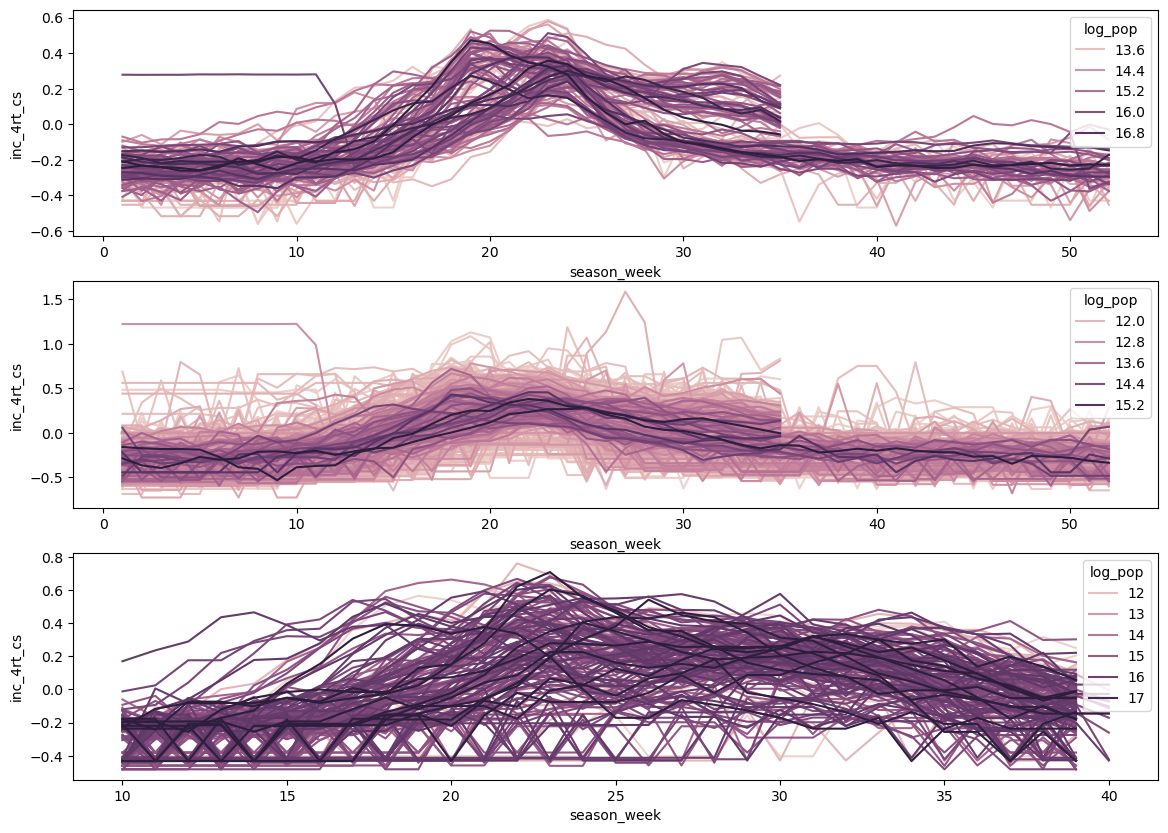

In [23]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(14, 10)

nhsn_state_to_plot = df.loc[df['source'] == 'nhsn_state'].assign(season_loc = lambda x: x['season'] + '_' + x['state_city'])
sns.lineplot(data=nhsn_state_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[0])

nhsn_city_to_plot = df.loc[df['source'] == 'nhsn_city'].assign(season_loc = lambda x: x['season'] + '_' + x['state_city'])
sns.lineplot(data=nhsn_city_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[1])


flusurv_to_plot = df.loc[df['source'] == 'flusurvnet'].assign(season_loc = lambda x: x['season'] + '_' + x['state_city'])
sns.lineplot(data=flusurv_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[2])

# Calculate features

### Misc. features based on date and location variables

In [24]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['source', 'state_city']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    get_holidays() \
      .query("holiday == 'Christmas Day'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

### Features summarizing time series within each source/location

In [25]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'state_city'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['state_city'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'state_city'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,
/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this w

      state city   season  season_week wk_end_date        inc      source  \
0        CA       2010/11         10.0  2010-10-09   0.432044  flusurvnet   
1        CA       2010/11         11.0  2010-10-16   0.432044  flusurvnet   
2        CA       2010/11         12.0  2010-10-23   0.000000  flusurvnet   
3        CA       2010/11         13.0  2010-10-30   0.432044  flusurvnet   
4        CA       2010/11         14.0  2010-11-06   0.000000  flusurvnet   
...     ...  ...      ...          ...         ...        ...         ...   
32904    WY       2023/24         31.0  2024-02-24  12.841212  nhsn_state   
32905    WY       2023/24         32.0  2024-03-02  10.101754  nhsn_state   
32906    WY       2023/24         33.0  2024-03-09   5.650133  nhsn_state   
32907    WY       2023/24         34.0  2024-03-16   5.136485  nhsn_state   
32908    WY       2023/24         35.0  2024-03-23   2.054594  nhsn_state   

      state_city location         pop  ...  \
0             CA       06  37

/Users/dk29776/Dropbox/UTAustin/Forecasting/flusion/src/timeseriesutils/src/timeseriesutils/featurize.py:507: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(taylor_coefs_one_column_grp,


In [26]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'source_flusurvnet',
 'source_nhsn_city',
 'source_nhsn_state',
 'state_city_AK',
 'state_city_AL',
 'state_city_AL_BIRMINGHAM',
 'state_city_AL_HUNTSVILLE',
 'state_city_AL_MOBILE',
 'state_city_AL_MONTGOMERY',
 'state_city_AL_TUSCALOOSA',
 'state_city_AR',
 'state_city_AR_FAYETTEVILLE',
 'state_city_AR_LITTLE_ROCK',
 'state_city_AZ',
 'state_city_AZ_CHANDLER',
 'state_city_AZ_GLENDALE',
 'state_city_AZ_GOODYEAR',
 'state_city_AZ_MESA',
 'state_city_AZ_PHOENIX',
 'state_city_AZ_SCOTTSDALE',
 'state_city_AZ_TEMPE',
 'state_city_AZ_TUCSON',
 'state_city_AZ_YUMA',
 'state_city_CA',
 'state_city_CA_ANAHEIM',
 'state_city_CA_ANTIOCH',
 'state_city_CA_BAKERSFIELD',
 'state_city_CA_BERKELEY',
 'state_city_CA_BURBANK',
 'state_city_CA_CHICO',
 'state_city_CA_CHULA_VISTA',
 'state_city_CA_CLOVIS',
 'state_city_CA_CORONA',
 'state_city_CA_COSTA_MESA',
 'state_city_CA_DOWNEY',
 'state_city_CA_FONTANA',
 'state_city_CA_FREMONT',
 'state_city_CA_FRESNO',

In [27]:
# if requested, drop features that involve absolute level
if not incl_level_feats:
  level_feats = ['inc_4rt_cs', 'inc_4rt_cs_lag1', 'inc_4rt_cs_lag2'] + \
                [f for f in feat_names if f.find('taylor_d0') > -1] + \
                [f for f in feat_names if f.find('inc_4rt_cs_rollmean') > -1]
  feat_names = [f for f in feat_names if f not in level_feats]

feat_names

['season_week',
 'log_pop',
 'source_flusurvnet',
 'source_nhsn_city',
 'source_nhsn_state',
 'state_city_AK',
 'state_city_AL',
 'state_city_AL_BIRMINGHAM',
 'state_city_AL_HUNTSVILLE',
 'state_city_AL_MOBILE',
 'state_city_AL_MONTGOMERY',
 'state_city_AL_TUSCALOOSA',
 'state_city_AR',
 'state_city_AR_FAYETTEVILLE',
 'state_city_AR_LITTLE_ROCK',
 'state_city_AZ',
 'state_city_AZ_CHANDLER',
 'state_city_AZ_GLENDALE',
 'state_city_AZ_GOODYEAR',
 'state_city_AZ_MESA',
 'state_city_AZ_PHOENIX',
 'state_city_AZ_SCOTTSDALE',
 'state_city_AZ_TEMPE',
 'state_city_AZ_TUCSON',
 'state_city_AZ_YUMA',
 'state_city_CA',
 'state_city_CA_ANAHEIM',
 'state_city_CA_ANTIOCH',
 'state_city_CA_BAKERSFIELD',
 'state_city_CA_BERKELEY',
 'state_city_CA_BURBANK',
 'state_city_CA_CHICO',
 'state_city_CA_CHULA_VISTA',
 'state_city_CA_CLOVIS',
 'state_city_CA_CORONA',
 'state_city_CA_COSTA_MESA',
 'state_city_CA_DOWNEY',
 'state_city_CA_FONTANA',
 'state_city_CA_FREMONT',
 'state_city_CA_FRESNO',
 'state_city_C

In [28]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'state_city'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
      state city   season  season_week wk_end_date        inc      source  \
0        CA       2010/11         10.0  2010-10-09   0.432044  flusurvnet   
1        CA       2010/11         11.0  2010-10-16   0.432044  flusurvnet   
2        CA       2010/11         12.0  2010-10-23   0.000000  flusurvnet   
3        CA       2010/11         13.0  2010-10-30   0.432044  flusurvnet   
4        CA       2010/11         14.0  2010-11-06   0.000000  flusurvnet   
...     ...  ...      ...          ...         ...        ...         ...   
32904    WY       2023/24         31.0  2024-02-24  12.841212  nhsn_state   
32905    WY       2023/24         32.0  2024-03-02  10.101754  nhsn_state   
32906    WY       2023/24         33.0  2024-03-09   5.650133  nhsn_state   
32907    WY       2023/24         34.0  2024-03-16   5.136485  nhsn_state   
32908    WY       2023/24         35.0  2024-03-23   2.054594  nhsn_state   

      state_city location         pop  ...  \
0             CA 

In [29]:
list(df_with_pred_targets.columns)

['state',
 'city',
 'season',
 'season_week',
 'wk_end_date',
 'inc',
 'source',
 'state_city',
 'location',
 'pop',
 'log_pop',
 'inc_4rt',
 'inc_4rt_scale_factor',
 'inc_4rt_cs',
 'inc_4rt_center_factor',
 'source_flusurvnet',
 'source_nhsn_city',
 'source_nhsn_state',
 'state_city_AK',
 'state_city_AL',
 'state_city_AL_BIRMINGHAM',
 'state_city_AL_HUNTSVILLE',
 'state_city_AL_MOBILE',
 'state_city_AL_MONTGOMERY',
 'state_city_AL_TUSCALOOSA',
 'state_city_AR',
 'state_city_AR_FAYETTEVILLE',
 'state_city_AR_LITTLE_ROCK',
 'state_city_AZ',
 'state_city_AZ_CHANDLER',
 'state_city_AZ_GLENDALE',
 'state_city_AZ_GOODYEAR',
 'state_city_AZ_MESA',
 'state_city_AZ_PHOENIX',
 'state_city_AZ_SCOTTSDALE',
 'state_city_AZ_TEMPE',
 'state_city_AZ_TUCSON',
 'state_city_AZ_YUMA',
 'state_city_CA',
 'state_city_CA_ANAHEIM',
 'state_city_CA_ANTIOCH',
 'state_city_CA_BAKERSFIELD',
 'state_city_CA_BERKELEY',
 'state_city_CA_BURBANK',
 'state_city_CA_CHICO',
 'state_city_CA_CHULA_VISTA',
 'state_city_CA_

In [30]:
df_with_pred_targets['wk_end_date'].max()

Timestamp('2024-03-23 00:00:00')

In [31]:
df_with_pred_targets['horizon']

0        1
1        1
2        1
3        1
4        1
        ..
32904    5
32905    5
32906    5
32907    5
32908    5
Name: horizon, Length: 164545, dtype: int64

In [32]:
# keep only rows that are in-season
df_with_pred_targets = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [33]:
# "test set" df used to generate look-ahead predictions
target_statecity = ['NY_NEW_YORK', 'CA_LOS_ANGELES', 
                        'IL_CHICAGO', 'TX_HOUSTON', 'AZ_PHOENIX',
                        'PA_PHILADELPHIA', 'NY_ROCHESTER', 'NY_ALBANY',
                        'TX_SAN_ANTONIO', 'TX_DALLAS', 'TX_AUSTIN',
                        'TX_EL_PASO']
df_test = df_with_pred_targets \
    .loc[(df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()) \
         & (df_with_pred_targets.source == 'nhsn_city')\
         & (df_with_pred_targets.state_city.isin(target_statecity))] \
    .copy()
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [34]:
df_test

,state,city,season,season_week,wk_end_date,inc,source,state_city,location,pop,...,inc_4rt_cs_taylor_d1_c0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_c1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
5677,AZ,PHOENIX,2023/24,35.0,2024-03-23,7.575436,nhsn_city,AZ_PHOENIX,NaN,1650070.0,...,0.001539,-0.014851,-0.012035,-0.016591,0.013731,-0.000359,0.017670,NaN,1,NaN
8026,CA,LOS_ANGELES,2023/24,35.0,2024-03-23,1.832022,nhsn_city,CA_LOS_ANGELES,NaN,3820914.0,...,-0.087904,-0.011538,-0.036261,-0.061342,-0.052894,-0.058268,-0.043271,NaN,1,NaN
14725,IL,CHICAGO,2023/24,35.0,2024-03-23,8.819825,nhsn_city,IL_CHICAGO,NaN,2664452.0,...,0.136606,-0.000709,0.007742,0.111277,0.129922,0.126664,0.124518,NaN,1,NaN
20467,NY,ALBANY,2023/24,35.0,2024-03-23,39.514759,nhsn_city,NY_ALBANY,NaN,101228.0,...,0.239610,-0.057040,-0.031091,0.181725,0.241564,0.231524,0.292885,NaN,1,NaN
20641,NY,NEW_YORK,2023/24,35.0,2024-03-23,2.894151,nhsn_city,NY_NEW_YORK,NaN,8258035.0,...,0.103824,-0.031768,-0.012095,0.058257,0.099552,0.100153,0.129239,NaN,1,NaN
20728,NY,ROCHESTER,2023/24,35.0,2024-03-23,25.087565,nhsn_city,NY_ROCHESTER,NaN,207274.0,...,0.236404,-0.022340,-0.012689,0.204061,0.240383,0.238047,0.258059,NaN,1,NaN
22381,PA,PHILADELPHIA,2023/24,35.0,2024-03-23,20.831425,nhsn_city,PA_PHILADELPHIA,NaN,1550542.0,...,0.213581,-0.019598,-0.000930,0.170915,0.214882,0.197093,0.219493,NaN,1,NaN
23599,TX,AUSTIN,2023/24,35.0,2024-03-23,4.694443,nhsn_city,TX_AUSTIN,NaN,979882.0,...,0.012914,-0.021692,-0.044842,0.035882,0.047084,0.049149,0.072432,NaN,1,NaN
24208,TX,DALLAS,2023/24,35.0,2024-03-23,19.802467,nhsn_city,TX_DALLAS,NaN,1302868.0,...,0.036647,-0.052502,-0.052720,0.015690,0.064865,0.066077,0.118805,NaN,1,NaN
24469,TX,EL_PASO,2023/24,35.0,2024-03-23,10.899054,nhsn_city,TX_EL_PASO,NaN,678958.0,...,0.019625,-0.016444,-0.020140,0.002496,0.041999,0.017356,0.040356,NaN,1,NaN


In [35]:
# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = rng.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
      # fit to bag
      model = lgb.LGBMRegressor(verbosity=-1,
                                  # hist_pool_size=1000,
                                  # objective='mean_absolute_error')
                                objective='quantile',
                                alpha = q_level,
                                random_state=lgb_seeds[b, q_ind])
      model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
      
      # oob predictions and test set predictions
      oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
      test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)


bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10


In [36]:
# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs.shape

(60, 23)

In [37]:
test_pred_qs_df = pd.DataFrame(test_pred_qs)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,-0.410295,-0.342163,-0.270222,-0.143802,-0.129266,-0.099973,-0.088862,-0.073186,-0.055604,-0.061194,...,-0.024937,-0.025814,-0.014298,-0.004396,0.009798,0.028550,0.023839,0.051922,0.046263,0.066487
1,-0.389155,-0.328112,-0.248930,-0.150357,-0.110303,-0.106834,-0.081430,-0.074048,-0.075417,-0.066696,...,-0.028230,-0.024072,-0.016423,-0.013618,0.000362,0.007446,0.014781,0.040763,0.068353,0.130579
2,-0.499862,-0.383742,-0.257147,-0.153056,-0.119693,-0.111055,-0.083852,-0.072044,-0.065198,-0.075562,...,-0.041210,-0.033870,-0.032236,-0.012335,-0.005868,0.006438,0.007982,0.039127,0.051248,0.098792
3,-0.535837,-0.484602,-0.427596,-0.272628,-0.192362,-0.136608,-0.109638,-0.080636,-0.076040,-0.077541,...,-0.032800,-0.026732,-0.024536,-0.002671,0.004219,0.050113,0.063649,0.091115,0.113932,0.141226
4,-0.408599,-0.363856,-0.309982,-0.181596,-0.136775,-0.110200,-0.089090,-0.071317,-0.064786,-0.071302,...,-0.041391,-0.037350,-0.026020,-0.016657,-0.008945,0.003121,-0.004537,0.031191,0.040383,0.083713
5,-0.564485,-0.466420,-0.333282,-0.191141,-0.150816,-0.111228,-0.090465,-0.076115,-0.070565,-0.073090,...,-0.035385,-0.035945,-0.028457,-0.003709,-0.000351,0.028599,0.040559,0.072532,0.110342,0.132203
6,-0.523725,-0.401260,-0.286083,-0.156220,-0.122149,-0.100934,-0.083293,-0.072583,-0.069864,-0.079135,...,-0.044751,-0.044476,-0.035850,-0.025423,-0.018842,0.001910,0.011059,0.032886,0.049151,0.086582
7,-0.417591,-0.376527,-0.305525,-0.180341,-0.130053,-0.106147,-0.094288,-0.054636,-0.059105,-0.055074,...,-0.025005,-0.019368,-0.014170,-0.003536,-0.001223,0.017224,0.033196,0.056023,0.058535,0.069692
8,-0.476639,-0.436529,-0.320556,-0.194280,-0.142474,-0.114604,-0.115589,-0.101509,-0.094936,-0.075349,...,-0.043686,-0.037086,-0.031199,-0.014766,-0.006809,0.000083,0.008558,0.040841,0.051284,0.083345
9,-0.425812,-0.395790,-0.302567,-0.195707,-0.138589,-0.109731,-0.093985,-0.077150,-0.060475,-0.061272,...,-0.025374,-0.027174,-0.013053,-0.006251,-0.000006,0.015118,0.031047,0.048759,0.056470,0.073714


In [38]:
df_test.reset_index(drop=True, inplace=True)

In [39]:
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,state,city,season,season_week,wk_end_date,inc,source,state_city,location,pop,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,AZ,PHOENIX,2023/24,35.0,2024-03-23,7.575436,nhsn_city,AZ_PHOENIX,NaN,1650070.0,...,-0.024937,-0.025814,-0.014298,-0.004396,0.009798,0.028550,0.023839,0.051922,0.046263,0.066487
1,CA,LOS_ANGELES,2023/24,35.0,2024-03-23,1.832022,nhsn_city,CA_LOS_ANGELES,NaN,3820914.0,...,-0.028230,-0.024072,-0.016423,-0.013618,0.000362,0.007446,0.014781,0.040763,0.068353,0.130579
2,IL,CHICAGO,2023/24,35.0,2024-03-23,8.819825,nhsn_city,IL_CHICAGO,NaN,2664452.0,...,-0.041210,-0.033870,-0.032236,-0.012335,-0.005868,0.006438,0.007982,0.039127,0.051248,0.098792
3,NY,ALBANY,2023/24,35.0,2024-03-23,39.514759,nhsn_city,NY_ALBANY,NaN,101228.0,...,-0.032800,-0.026732,-0.024536,-0.002671,0.004219,0.050113,0.063649,0.091115,0.113932,0.141226
4,NY,NEW_YORK,2023/24,35.0,2024-03-23,2.894151,nhsn_city,NY_NEW_YORK,NaN,8258035.0,...,-0.041391,-0.037350,-0.026020,-0.016657,-0.008945,0.003121,-0.004537,0.031191,0.040383,0.083713
5,NY,ROCHESTER,2023/24,35.0,2024-03-23,25.087565,nhsn_city,NY_ROCHESTER,NaN,207274.0,...,-0.035385,-0.035945,-0.028457,-0.003709,-0.000351,0.028599,0.040559,0.072532,0.110342,0.132203
6,PA,PHILADELPHIA,2023/24,35.0,2024-03-23,20.831425,nhsn_city,PA_PHILADELPHIA,NaN,1550542.0,...,-0.044751,-0.044476,-0.035850,-0.025423,-0.018842,0.001910,0.011059,0.032886,0.049151,0.086582
7,TX,AUSTIN,2023/24,35.0,2024-03-23,4.694443,nhsn_city,TX_AUSTIN,NaN,979882.0,...,-0.025005,-0.019368,-0.014170,-0.003536,-0.001223,0.017224,0.033196,0.056023,0.058535,0.069692
8,TX,DALLAS,2023/24,35.0,2024-03-23,19.802467,nhsn_city,TX_DALLAS,NaN,1302868.0,...,-0.043686,-0.037086,-0.031199,-0.014766,-0.006809,0.000083,0.008558,0.040841,0.051284,0.083345
9,TX,EL_PASO,2023/24,35.0,2024-03-23,10.899054,nhsn_city,TX_EL_PASO,NaN,678958.0,...,-0.025374,-0.027174,-0.013053,-0.006251,-0.000006,0.015118,0.031047,0.048759,0.056470,0.073714


In [40]:
oob_pred_qs.shape

(135085, 23)

In [ ]:
# # predictions
# df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']

# for q_level, q_label in zip(q_levels, q_labels):
#     # basically do an out-of-sample bootstrap per location and horizon to get quantiles
#     oob_resid_q = df_train.groupby(['location', 'horizon'])['oob_pred_resid'].quantile(q_level)
#     df_test = df_test.merge(oob_resid_q.reset_index(), on=['location', 'horizon'])
#     df_test[q_label] = df_test['delta_hat_stage1'] + df_test['oob_pred_resid']
#     df_test.drop(columns=['oob_pred_resid'], inplace=True)

In [41]:
df_test_w_preds.loc[df_test_w_preds['state_city'] == 'TX_HOUSTON', 'inc']

10    7.77821
22    7.77821
34    7.77821
46    7.77821
58    7.77821
Name: inc, dtype: float64

In [42]:
df_test_w_preds

,state,city,season,season_week,wk_end_date,inc,source,state_city,location,pop,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,AZ,PHOENIX,2023/24,35.0,2024-03-23,7.575436,nhsn_city,AZ_PHOENIX,NaN,1650070.0,...,-0.024937,-0.025814,-0.014298,-0.004396,0.009798,0.028550,0.023839,0.051922,0.046263,0.066487
1,CA,LOS_ANGELES,2023/24,35.0,2024-03-23,1.832022,nhsn_city,CA_LOS_ANGELES,NaN,3820914.0,...,-0.028230,-0.024072,-0.016423,-0.013618,0.000362,0.007446,0.014781,0.040763,0.068353,0.130579
2,IL,CHICAGO,2023/24,35.0,2024-03-23,8.819825,nhsn_city,IL_CHICAGO,NaN,2664452.0,...,-0.041210,-0.033870,-0.032236,-0.012335,-0.005868,0.006438,0.007982,0.039127,0.051248,0.098792
3,NY,ALBANY,2023/24,35.0,2024-03-23,39.514759,nhsn_city,NY_ALBANY,NaN,101228.0,...,-0.032800,-0.026732,-0.024536,-0.002671,0.004219,0.050113,0.063649,0.091115,0.113932,0.141226
4,NY,NEW_YORK,2023/24,35.0,2024-03-23,2.894151,nhsn_city,NY_NEW_YORK,NaN,8258035.0,...,-0.041391,-0.037350,-0.026020,-0.016657,-0.008945,0.003121,-0.004537,0.031191,0.040383,0.083713
5,NY,ROCHESTER,2023/24,35.0,2024-03-23,25.087565,nhsn_city,NY_ROCHESTER,NaN,207274.0,...,-0.035385,-0.035945,-0.028457,-0.003709,-0.000351,0.028599,0.040559,0.072532,0.110342,0.132203
6,PA,PHILADELPHIA,2023/24,35.0,2024-03-23,20.831425,nhsn_city,PA_PHILADELPHIA,NaN,1550542.0,...,-0.044751,-0.044476,-0.035850,-0.025423,-0.018842,0.001910,0.011059,0.032886,0.049151,0.086582
7,TX,AUSTIN,2023/24,35.0,2024-03-23,4.694443,nhsn_city,TX_AUSTIN,NaN,979882.0,...,-0.025005,-0.019368,-0.014170,-0.003536,-0.001223,0.017224,0.033196,0.056023,0.058535,0.069692
8,TX,DALLAS,2023/24,35.0,2024-03-23,19.802467,nhsn_city,TX_DALLAS,NaN,1302868.0,...,-0.043686,-0.037086,-0.031199,-0.014766,-0.006809,0.000083,0.008558,0.040841,0.051284,0.083345
9,TX,EL_PASO,2023/24,35.0,2024-03-23,10.899054,nhsn_city,TX_EL_PASO,NaN,678958.0,...,-0.025374,-0.027174,-0.013053,-0.006251,-0.000006,0.015118,0.031047,0.048759,0.056470,0.073714


In [43]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['source', 'state_city', 'wk_end_date', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = preds_df.loc[(preds_df['source'] == 'nhsn_city')]
preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)

# keep just required columns and rename to match hub format
preds_df = preds_df[['state_city', 'wk_end_date', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['horizon'] = preds_df['horizon'] - 2
preds_df['target'] = 'wk inc flu hosp'

preds_df['output_type'] = 'quantile'
preds_df.drop(columns='wk_end_date', inplace=True)

preds_df

,state_city,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,AZ_PHOENIX,-1,0.01,0.000000,2024-03-30,2024-03-30,wk inc flu hosp,quantile
1,CA_LOS_ANGELES,-1,0.01,0.000000,2024-03-30,2024-03-30,wk inc flu hosp,quantile
2,IL_CHICAGO,-1,0.01,0.000000,2024-03-30,2024-03-30,wk inc flu hosp,quantile
3,NY_ALBANY,-1,0.01,0.000000,2024-03-30,2024-03-30,wk inc flu hosp,quantile
4,NY_NEW_YORK,-1,0.01,0.000000,2024-03-30,2024-03-30,wk inc flu hosp,quantile
...,...,...,...,...,...,...,...,...
1375,TX_AUSTIN,3,0.99,65.213834,2024-04-27,2024-03-30,wk inc flu hosp,quantile
1376,TX_DALLAS,3,0.99,414.236799,2024-04-27,2024-03-30,wk inc flu hosp,quantile
1377,TX_EL_PASO,3,0.99,117.767823,2024-04-27,2024-03-30,wk inc flu hosp,quantile
1378,TX_HOUSTON,3,0.99,383.944220,2024-04-27,2024-03-30,wk inc flu hosp,quantile


In [44]:
# sort quantiles to avoid quantile crossing
gcols = ['state_city', 'reference_date', 'horizon', 'target_end_date', 'target', 'output_type']
g = preds_df.set_index(gcols).groupby(gcols)
preds_df = g[['output_type_id', 'value']] \
  .transform(lambda x: x.sort_values()) \
  .reset_index()


In [45]:
if not Path('model-output/gbq_qr_no_level-statecity').exists():
    Path('model-output/gbq_qr_no_level-statecity').mkdir(parents=True)

preds_df.to_csv(f'model-output/gbq_qr_no_level-statecity/{str(ref_date)}-gbq_qr_no_level.csv', index=False)